In [1]:
# !pip install numpy scipy matplotlib

# Gathering Annotated Audio Snippets

In [1]:
import os
import numpy as np
from scipy.io import wavfile
import math

In [2]:
shot_timestamps = [0,6.5,8, 11, 18.5, 23, 27, 29, 32, 37, 43.5, 47.5, 52, 55.5, 63, 66, 68, 72, 75, 79, 94.5, 96, 99, 105, 122, 115] 
shot_labels = ['no', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no','no','no', 'no', 'yes', 'yes', 'no', 'no', 'yes', 'yes']

In [3]:
shot_timestamps = [float(x) for x in shot_timestamps] 

In [4]:
from pydub import AudioSegment 
from pydub.playback import play
import IPython

def play_audios(shot_timestamps, PATH_AUDIO): 
    newAudio = AudioSegment.from_wav(os.path.join('data','source.wav'))   
    
    for i,timestamp in enumerate(shot_timestamps): 
        start = math.ceil(timestamp*1000)
        end = math.ceil((timestamp + 1)*1000)
        snippet = newAudio[start:end] 
        print(f'Audio {i}') 
        filepath = os.path.join(PATH_AUDIO, str(i)+'.wav')
        snippet.export(filepath, format="wav") 
        rate, snippet = wavfile.read(filepath);
        snippet = np.array(snippet[:,0], dtype='float')
        IPython.display.display(IPython.display.Audio(snippet, rate=48000))
        print('-------') 

In [48]:
PATH_AUDIO = os.path.join('data','spectrograms', 'audios')  
play_audios(shot_timestamps, PATH_AUDIO) 

Audio 0


-------
Audio 1


-------
Audio 2


-------
Audio 3


-------
Audio 4


-------
Audio 5


-------
Audio 6


-------
Audio 7


-------
Audio 8


-------
Audio 9


-------
Audio 10


-------
Audio 11


-------
Audio 12


-------
Audio 13


-------
Audio 14


-------
Audio 15


-------
Audio 16


-------
Audio 17


-------
Audio 18


-------
Audio 19


-------
Audio 20


-------
Audio 21


-------
Audio 22


-------
Audio 23


-------
Audio 24


-------
Audio 25


-------


In [5]:
source = os.path.join('data','source.wav') 
rate, source = wavfile.read(source) 
source = np.array(source[:,0], dtype='float')

In [6]:
def get_audio_snippets(shot_timestamps): 

    shot_snippets = []  # Collection of all audio snippets in the timestamps above 

    for timestamp in shot_timestamps: 
        start = math.ceil(timestamp*rate)
        end = math.ceil((timestamp + 1)*rate)
        if start >= source.shape[0]: 
            start = source.shape[0] - 1

        if end >= source.shape[0]: 
            end = source.shape[0] - 1  

        shot_snippets.append(source[start:end]) 
        
    return shot_snippets

In [7]:
shot_snippets = get_audio_snippets(shot_timestamps) 

# Converting Audio To Spectrogram

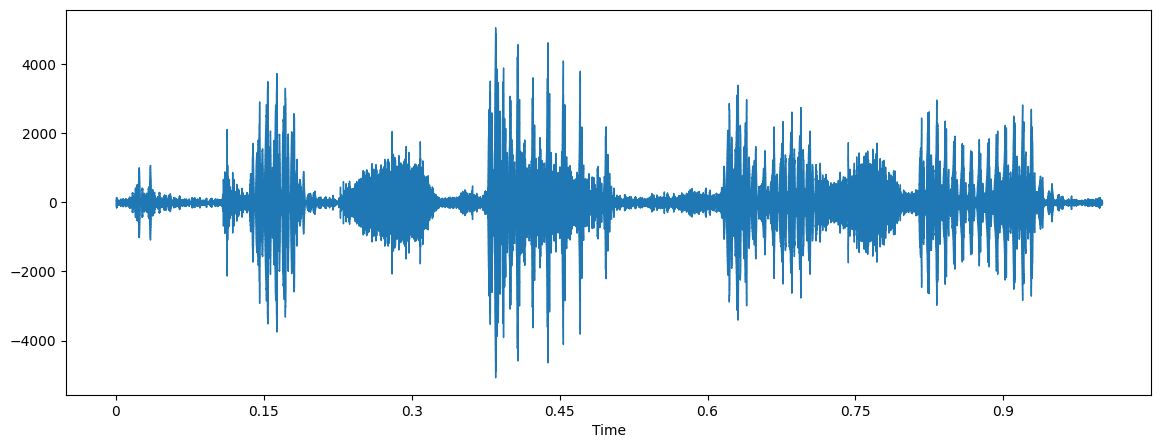

In [8]:
# Visualizing one of the snippet waveform 

import librosa.display
import matplotlib.pyplot as plt 

plt.figure(figsize=(14, 5))
librosa.display.waveshow(shot_snippets[0], sr=rate) 

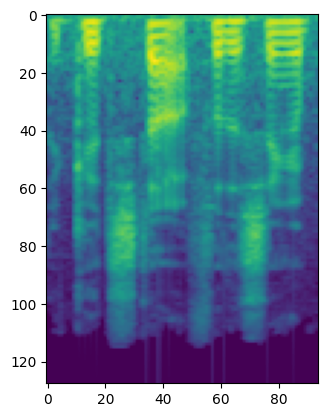

In [9]:
# Visualizing Spectrogram of above snippet 

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

mels = librosa.feature.melspectrogram(y=shot_snippets[0],sr=rate, window='hamming')
fig = plt.Figure()
canvas = FigureCanvas(fig)
p = plt.imshow(librosa.power_to_db(mels,ref=np.max))

In [10]:
# Converting all snippets to spectogram images 

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import librosa.display
import matplotlib.pyplot as plt 
import csv  


def save_spectrograms(shot_snippets, shot_labels, PATH_SPECTROGRAMS, PATH_CSV):  
    
    fields = ['spectrogram', 'label']
    with open(PATH_CSV, 'a') as csvfile:   
        csvwriter = csv.writer(csvfile) 
        csvwriter.writerow(fields)  

        for i,snippet in enumerate(shot_snippets): 
            mels = librosa.feature.melspectrogram(y=shot_snippets[0],sr=rate, window='hamming')
            fig = plt.Figure(figsize=(1.0,1.4))
            canvas = FigureCanvas(fig)
            p = plt.imshow(librosa.power_to_db(mels,ref=np.max)) 
            filepath = os.path.join(PATH_SPECTROGRAMS, 'snippet_'+str(i)+'.png')
            csvwriter.writerow([filepath, shot_labels[i]]) 
            plt.savefig(filepath)  

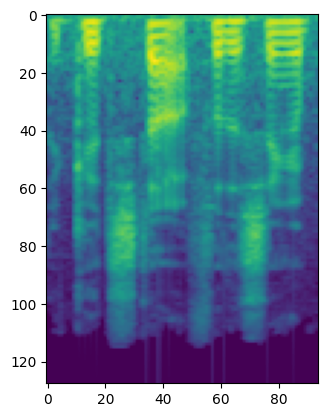

In [11]:
PATH_SPECTROGRAMS = os.path.join('data','spectrograms', 'images')  
PATH_CSV = os.path.join('data','spectrograms', 'point_of_contact.csv')

save_spectrograms(shot_snippets, shot_labels,PATH_SPECTROGRAMS, PATH_CSV) 

# Generating Data for CNN 

In [12]:
import pandas as pd
import os

df = pd.read_csv(PATH_CSV)
df.head()

,spectrogram,label
0,data\spectrograms\images\snippet_0.png,no
1,data\spectrograms\images\snippet_1.png,yes
2,data\spectrograms\images\snippet_2.png,yes
3,data\spectrograms\images\snippet_3.png,yes
4,data\spectrograms\images\snippet_4.png,yes


In [16]:
# Rescaling Images

from skimage import io 
from skimage.transform import rescale 
from sklearn import preprocessing
import tensorflow as tf 

urls = df['spectrogram'] 
X = [] 

le = preprocessing.LabelEncoder()
le.fit(df.label)
df['categorical_label'] = le.transform(df.label)

y = np.array(df['categorical_label']) 
y = tf.keras.utils.to_categorical(y ,num_classes=2)  

for url in urls: 
    img = io.imread(url, as_gray = True) 
    img = rescale(img, 0.5 , anti_aliasing = True) 
    img = img.reshape([img.shape[0],img.shape[1],1])
    X.append(img) 

In [17]:
X = np.array(X) 
X.shape 

(26, 240, 320, 1)

In [18]:
y.shape 

(26, 2)

## Splitting into Train/Test

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)  

## CNN Model Training

In [24]:
xavier_init = tf.keras.initializers.GlorotNormal(seed=0) 

model = tf.keras.Sequential([
    # Add Convo Layers here 
    tf.keras.layers.Conv2D(filters=30, kernel_size=3, activation='relu', input_shape = [X.shape[1],X.shape[2],1]),  
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2), 
    tf.keras.layers.Conv2D(filters=30, kernel_size=3, activation='relu'),  
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    # Add ANN here 
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(units = 128, activation= 'relu', kernel_initializer=xavier_init),  # Hidden Layer 2
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units = 128, activation= 'relu', kernel_initializer=xavier_init),  # Hidden Layer 2
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 2, activation= 'softmax', kernel_initializer= xavier_init)  # Output Layer 
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

In [25]:
model.fit(
    X_train, y_train, 
    batch_size=6, 
    epochs = 8, 
    verbose = 2, 
    validation_data=(X_test, y_test)
) 

Epoch 1/8
4/4 - 2s - loss: 0.9409 - accuracy: 0.5500 - val_loss: 0.8066 - val_accuracy: 0.1667 - 2s/epoch - 475ms/step
Epoch 2/8
4/4 - 1s - loss: 0.6938 - accuracy: 0.6000 - val_loss: 0.7589 - val_accuracy: 0.1667 - 1s/epoch - 287ms/step
Epoch 3/8
4/4 - 1s - loss: 0.6901 - accuracy: 0.6000 - val_loss: 0.7592 - val_accuracy: 0.1667 - 1s/epoch - 284ms/step
Epoch 4/8
4/4 - 1s - loss: 0.6660 - accuracy: 0.6500 - val_loss: 0.7911 - val_accuracy: 0.1667 - 1s/epoch - 274ms/step
Epoch 5/8
4/4 - 1s - loss: 0.6563 - accuracy: 0.6500 - val_loss: 0.9031 - val_accuracy: 0.1667 - 1s/epoch - 282ms/step
Epoch 6/8
4/4 - 1s - loss: 0.6859 - accuracy: 0.6500 - val_loss: 0.9776 - val_accuracy: 0.1667 - 1s/epoch - 279ms/step
Epoch 7/8
4/4 - 1s - loss: 0.7146 - accuracy: 0.6500 - val_loss: 0.9252 - val_accuracy: 0.1667 - 1s/epoch - 275ms/step
Epoch 8/8
4/4 - 1s - loss: 0.6370 - accuracy: 0.6500 - val_loss: 0.9259 - val_accuracy: 0.1667 - 1s/epoch - 275ms/step


# Visualizing Hit Frames 

In [1]:
import cv2
import os

VFILENAME = os.path.join('data', 'match2.mp4')
HEIGHT = 720
WIDTH = 1280

In [2]:
def get_frames(filename): 
    video = cv2.VideoCapture(filename) 
    frame_id = -1 
    while video.isOpened(): 
        ret, frame = video.read() 
        frame_id += 1 
        if ret: 
            yield frame, frame_id 
        else: 
            break 
    video.release() 
    yield None 

In [3]:
frames_hit = [] 
PATH_TIMESTAMPS = os.path.join('timestamps2.txt') 
with open(PATH_TIMESTAMPS,'r') as f: 
    timestamps = f.read().split(',') 
    for i,second in enumerate(timestamps):
        frame_id = int(30.0*float(second))
        frames_hit.append(frame_id)  

In [4]:
len(frames_hit) 

276

In [4]:
font = cv2.FONT_HERSHEY_PLAIN  

for frame, frame_id in get_frames(VFILENAME):
    if frame is None: break 
        
    if frame_id in frames_hit: 
        cv2.putText(frame, 'HIT POINT', (0, HEIGHT-20), font,2,(255,255,255), 2) 
        
    else: 
        cv2.putText(frame, 'NON-HIT POINT', (0, HEIGHT-20), font,2,(255,255,255), 2)  
        
    cv2.imshow('frame',frame) 
    
    # 27 is the escape key. The number in the function is waiting time
    if cv2.waitKey(30) == 27:
        if cv2.waitKey(0) == 27:
            break  
            
cv2.destroyAllWindows() 